# Submission Nicolo Lüscher

In [690]:
# import libraries
from skimage import io, color, feature, transform, measure
from skimage.filters import gaussian, threshold_otsu
from skimage.morphology import dilation, square
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os

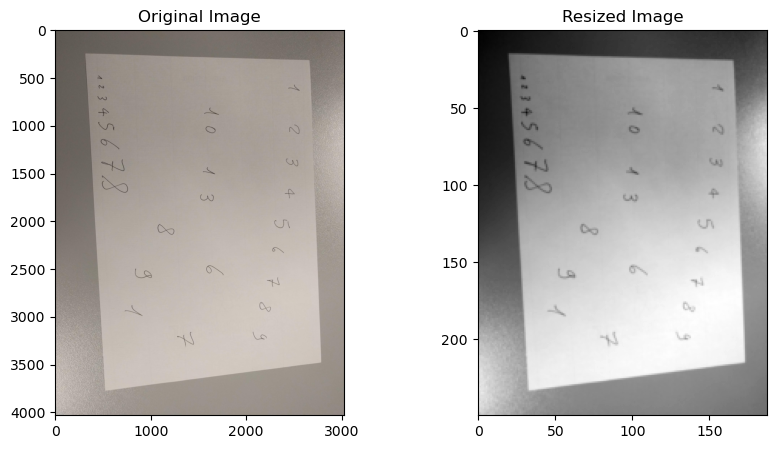

In [691]:
# load image
full_image = io.imread("./images/homework images vol 2/" + os.listdir("./images/homework images vol 2/")[1])
dest_size = 250

# resize image
reduced_image = transform.resize(full_image, (dest_size, dest_size*(full_image.shape[1]/full_image.shape[0])), anti_aliasing=True)
# convert to grayscale
gray_image = color.rgb2gray(reduced_image)


# plotting
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(full_image)
ax[1].imshow(gray_image, cmap='gray')
ax[0].set_title('Original Image')
ax[1].set_title('Resized Image')
plt.show()


Text(0.5, 1.0, 'Binary Image')

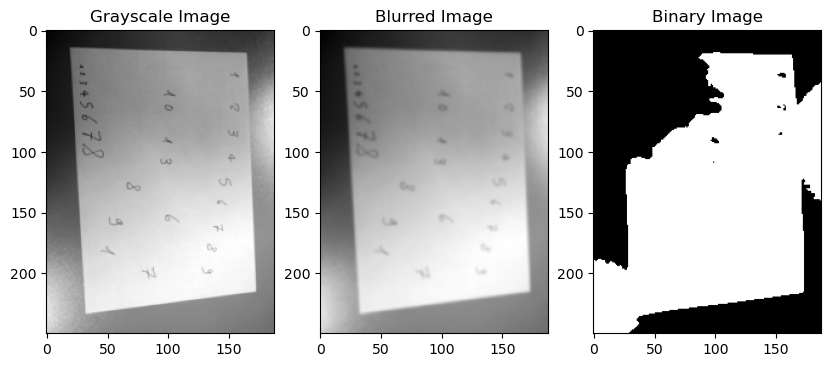

In [692]:

blurred_image = gaussian(gray_image, sigma=1)

# threshold image
thresh = threshold_otsu(blurred_image)
binary_image = blurred_image > thresh

# plotting
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(gray_image, cmap='gray')
ax[0].set_title('Grayscale Image')
ax[1].imshow(blurred_image, cmap='gray')
ax[1].set_title('Blurred Image')
ax[2].imshow(binary_image, cmap='gray')
ax[2].set_title('Binary Image')

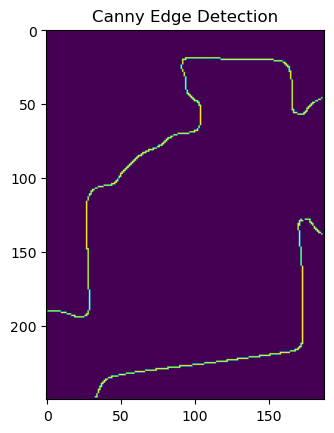

In [693]:
# dilate image
imedges = feature.canny(binary_image, sigma=5)

# plotting
plt.title('Canny Edge Detection')
plt.imshow(imedges)
plt.show()

Line 0: d = 238.0, theta = 82.0
Line 1: d = 25.0, theta = -1.0
Line 2: d = 173.0, theta = 0.0
Line 3: d = -15.0, theta = -88.0
Line 4: d = 105.0, theta = 45.0


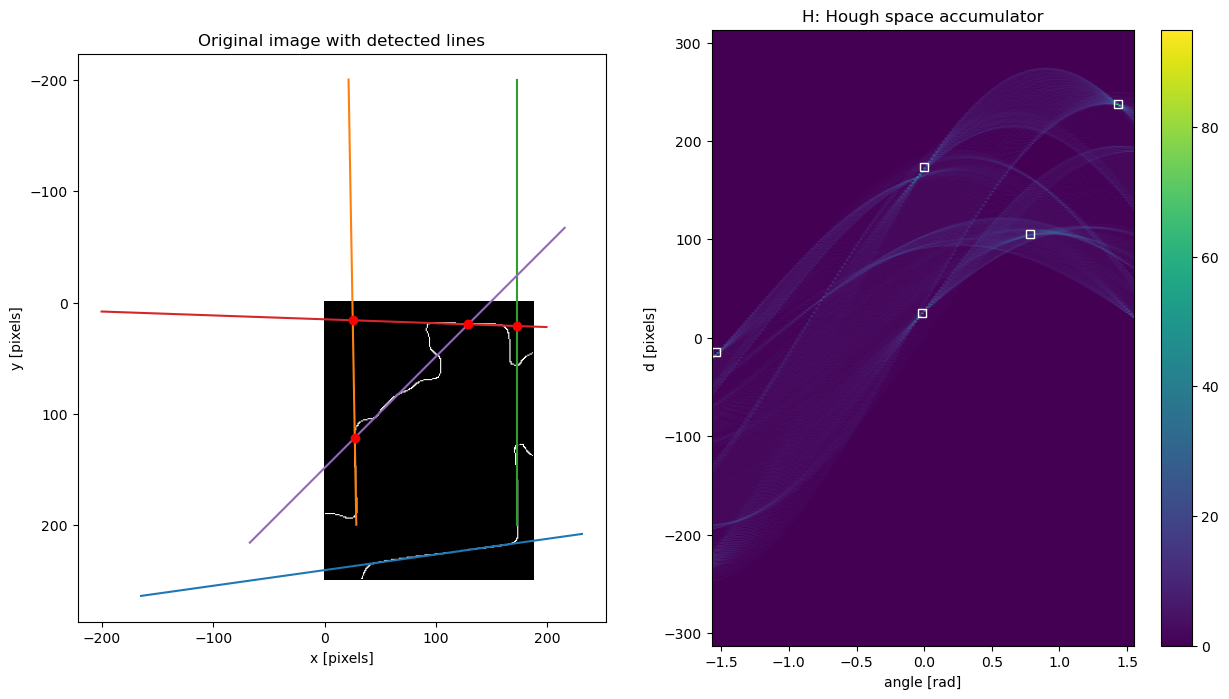

In [694]:
# perform Hough transform
H, angles, distances = transform.hough_line(imedges)

# find the indices of the top 20 highest values in H
k = 50
flattened_indices = np.argpartition(H.ravel(), -k)[-k:]
indices_2D = np.unravel_index(flattened_indices, H.shape)

# extract and sort the corresponding distances and angles
distances_max = distances[indices_2D[0]]
angles_max = angles[indices_2D[1]]
sorted_indices = np.argsort(H[indices_2D])[::-1]
distances_max = distances_max[sorted_indices]
angles_max = angles_max[sorted_indices]

# initialize lists to store accepted distances and angles
accepted_distances = []
accepted_angles = []

# set thresholds for filtering lines
distance_threshold = 50  # pixels
angle_threshold = 0.4  # radians

# plotting
fig, (ax0, ax1) = plt.subplots(ncols=2, nrows=1, figsize=(15, 8))
ax0.set(xlabel="x [pixels]", ylabel="y [pixels]", title="Original image with detected lines")
ax0.imshow(imedges, cmap="gray")
Himage = ax1.imshow(H, extent=(angles[0], angles[-1], distances[0], distances[-1]), origin="lower", aspect="auto")
ax1.set(xlabel="angle [rad]", ylabel="d [pixels]", title="H: Hough space accumulator")
plt.colorbar(Himage)

# loop through the sorted highest values and filter lines
for i in range(k):
    d = distances_max[i]
    theta = angles_max[i]
    
    # check if the line is too close or parallel to already accepted lines
    if len(accepted_distances) > 0:
        distances_diff = np.abs(np.abs(d) - np.abs(np.array(accepted_distances)))
        angles_diff = [np.arccos(np.cos(theta - accepted_theta)) for accepted_theta in accepted_angles]
        if any((distances_diff < distance_threshold) & ((np.array(angles_diff) < angle_threshold) | (np.array(angles_diff) > np.pi - angle_threshold))):
            continue
    
    # add the line to the list of accepted lines
    accepted_distances.append(d)
    accepted_angles.append(theta)
    
    # plot a white rectangle over the maximum in Hough space
    ax1.plot(theta, d, "ws", fillstyle="none")
    
    # draw the line in image space
    p1 = np.array([d * np.cos(theta), d * np.sin(theta)])
    linedir = np.array([np.cos(theta + np.pi / 2), np.sin(theta + np.pi / 2)])
    p0 = p1 - linedir * 200
    p2 = p1 + linedir * 200
    ax0.plot([p0[0], p2[0]], [p0[1], p2[1]], scalex=False, scaley=False)

for i in range(len(accepted_distances)):
    print("Line {}: d = {:.1f}, theta = {:.1f}".format(i, accepted_distances[i], accepted_angles[i] * 180 / np.pi))

# initialize list to store intersection points
intersections = []

# loop through all pairs of lines to find intersections
for i in range(len(accepted_distances)):
    for j in range(i + 1, len(accepted_distances)):
        d1, theta1 = accepted_distances[i], accepted_angles[i]
        d2, theta2 = accepted_distances[j], accepted_angles[j]
        
        # direction vectors
        dir1 = np.array([np.cos(theta1 + np.pi / 2), np.sin(theta1 + np.pi / 2)])
        dir2 = np.array([np.cos(theta2 + np.pi / 2), np.sin(theta2 + np.pi / 2)])
        
        # points on the lines
        p1 = np.array([d1 * np.cos(theta1), d1 * np.sin(theta1)])
        p2 = np.array([d2 * np.cos(theta2), d2 * np.sin(theta2)])
        
        # Solve for intersection
        A = np.vstack([dir1, -dir2]).T
        b = p2 - p1
        if np.linalg.matrix_rank(A) == 2:  # lines are not parallel
            t, s = np.linalg.solve(A, b)
            intersection = p1 + t * dir1
            intersections.append(intersection)

# get the dimensions of the image
height, width = imedges.shape


# take to four intersections closest to the center of the image
intersections = np.array(intersections)
center = np.array([height / 2, width / 2])
distances = np.linalg.norm(intersections - center, axis=1)
sorted_indices = np.argsort(distances)
intersections = intersections[sorted_indices[:4]]

# plot intersections on the image
for intersection in intersections:
    ax0.plot(intersection[0], intersection[1], 'ro')
plt.show()

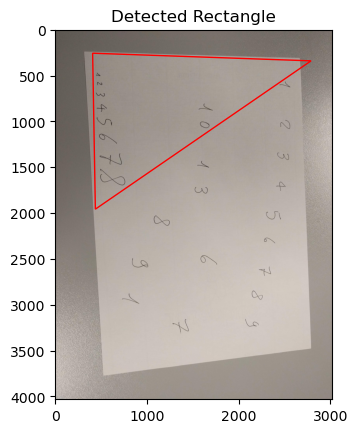

In [695]:
# create figure and axes
fig, ax = plt.subplots(1)

# rescale points to match the original image
intersections = np.array(intersections) * (full_image.shape[0] / dest_size)

# display the image
ax.imshow(full_image)

# calculate the centroid
centroid = np.mean(intersections, axis=0)

# sort the points based on the angle with the centroid
sorted_points = sorted(intersections, key=lambda point: -np.arctan2(point[1] - centroid[1], point[0] - centroid[0]))

# create a rectangle patch
rect = patches.Polygon(sorted_points, closed=True, edgecolor='r', facecolor='none')

# add the patch to the axes
ax.add_patch(rect)

# plotting
ax.set_title('Detected Rectangle')
plt.show()

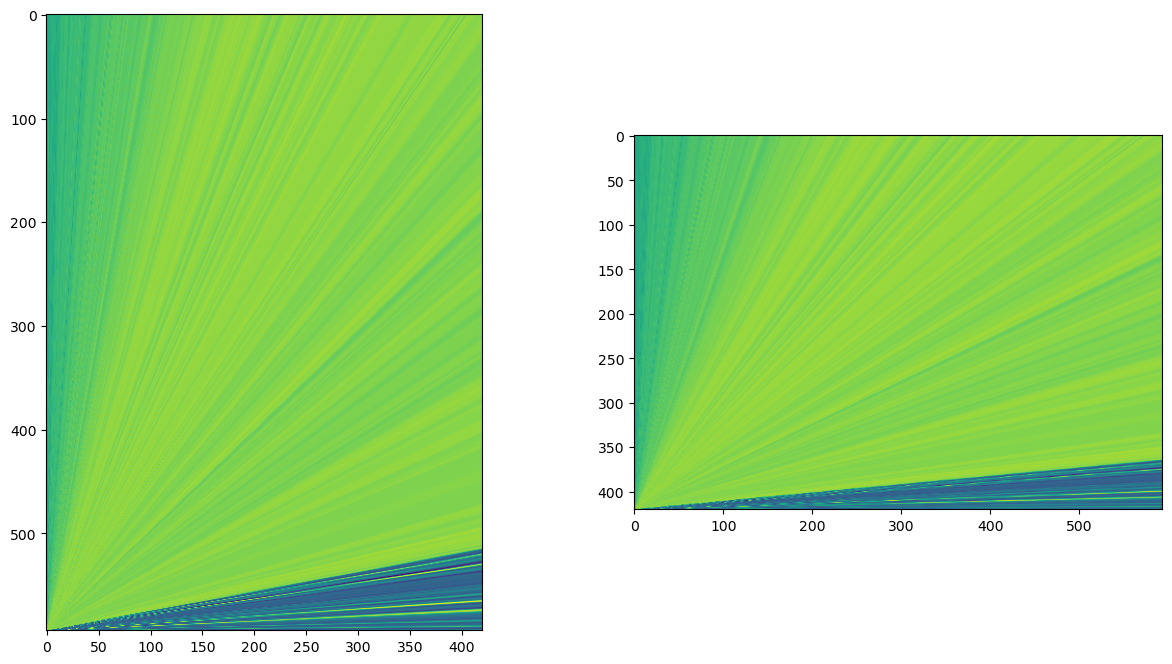

In [696]:
a, b, c, d = sorted_points[:4]
w,h = 210 * 2,297 * 2 # we assume 10 pixels per mm
A = np.array([0,h])
B = np.array([w,h])
C = np.array([w,0])
D = np.array([0,0])
invtf = transform.estimate_transform(
    "projective", src=np.vstack((A, B, C, D)), dst=np.vstack((a, b, c, d))
)

# wrap the image
warped = transform.warp(full_image, inverse_map=invtf, output_shape=(h, w))

# set the background to the average color of the image
warped[warped.sum(axis=2) == 0] = warped.mean(axis=(0, 1))

warped = color.rgb2gray(warped)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 8))
ax1.imshow(warped)
ax2.imshow(transform.resize(warped, (210*2, 297*2)))
plt.show()

Text(0.5, 1.0, 'Dilated Image')

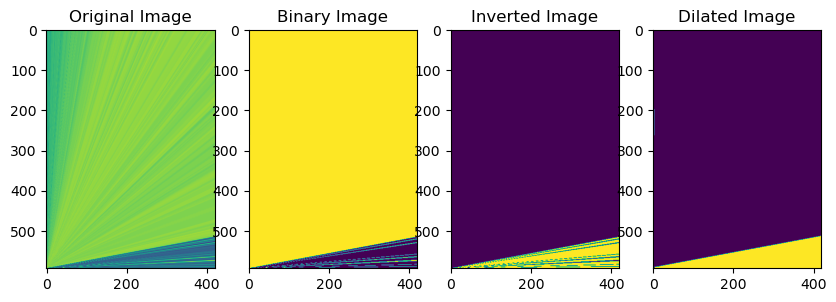

In [697]:
# boost contrast
boosted_contrast = np.clip(warped * 1.5, 0, 1)

# binarize image
thresh = threshold_otsu(boosted_contrast)
binary_image = boosted_contrast > thresh

# invert image
gray_image = 1 - binary_image

# dilate image
dilated_image = dilation(gray_image, square(4))

# plotting
fig, ax = plt.subplots(1, 4, figsize=(10, 5))
ax[0].imshow(warped)
ax[0].set_title('Original Image')
ax[1].imshow(binary_image)
ax[1].set_title('Binary Image')
ax[2].imshow(gray_image)
ax[2].set_title('Inverted Image')
ax[3].imshow(dilated_image)
ax[3].set_title('Dilated Image')

Text(0.5, 1.0, 'Labeled Image')

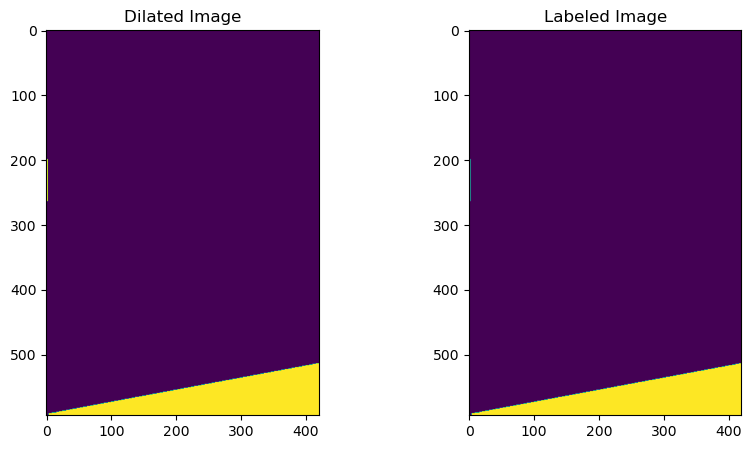

In [698]:
# perform connected component analysis
labeled_image = measure.label(dilated_image)

# plotting
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(dilated_image)
ax[0].set_title('Dilated Image')
ax[1].imshow(labeled_image)
ax[1].set_title('Labeled Image')


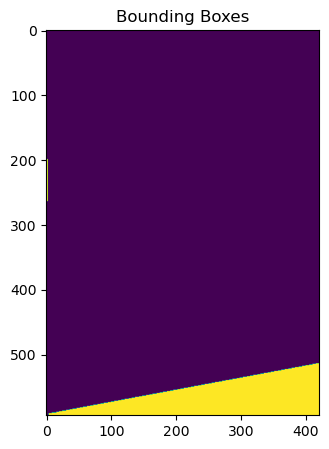

In [699]:
# loop through all connected components
bounding_boxes = []
for region in measure.regionprops(labeled_image):
        
        # skip too small and too large regions
        if region.area < 60 or region.area > 10000:
            continue
        
        # extract the bounding box coordinates
        minr, minc, maxr, maxc = region.bbox

        # skip images that are not roughly square
        if (maxr - minr) / (maxc - minc) > 4 or (maxc - minc) / (maxr - minr) > 4:
            continue

        # check if the bounding box is too close to the edge of the image
        if minr < 10 or minc < 10 or maxr > dilated_image.shape[0] - 10 or maxc > dilated_image.shape[1] - 10:
            continue
        
        # add the bounding box coordinates to the list with a 10 pixel margin
        bounding_boxes.append((minr - 10, minc - 10, maxr + 10, maxc + 10))

# plotting
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.imshow(dilated_image)

# loop through the bounding boxes and draw them on the image
for minr, minc, maxr, maxc in bounding_boxes:
    rect = patches.Rectangle((minc, minr), maxc - minc, maxr - minr, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

ax.set_title('Bounding Boxes')
plt.show()

In [700]:
accepted_bounding_boxes = []

# loop through the bounding boxes

for minr, minc, maxr, maxc in bounding_boxes:
        
        # check if the bounding box is too close to an already accepted bounding box
        if len(accepted_bounding_boxes) > 0:
            distances = np.array([np.abs(minr - accepted_minr) for accepted_minr, _, _, _ in accepted_bounding_boxes])
            if any(distances < 10):
                continue
        
        # add the bounding box to the list of accepted bounding boxes
        accepted_bounding_boxes.append((minr, minc, maxr, maxc))

# plotting
fig, ax = plt.subplots(1, len(bounding_boxes), figsize=(10, 5))
for i, (minr, minc, maxr, maxc) in enumerate(bounding_boxes):
    ax[i].imshow(dilated_image[minr:maxr, minc:maxc])
plt.show()

ValueError: Number of columns must be a positive integer, not 0

<Figure size 1000x500 with 0 Axes>